In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from ZAVTRA;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

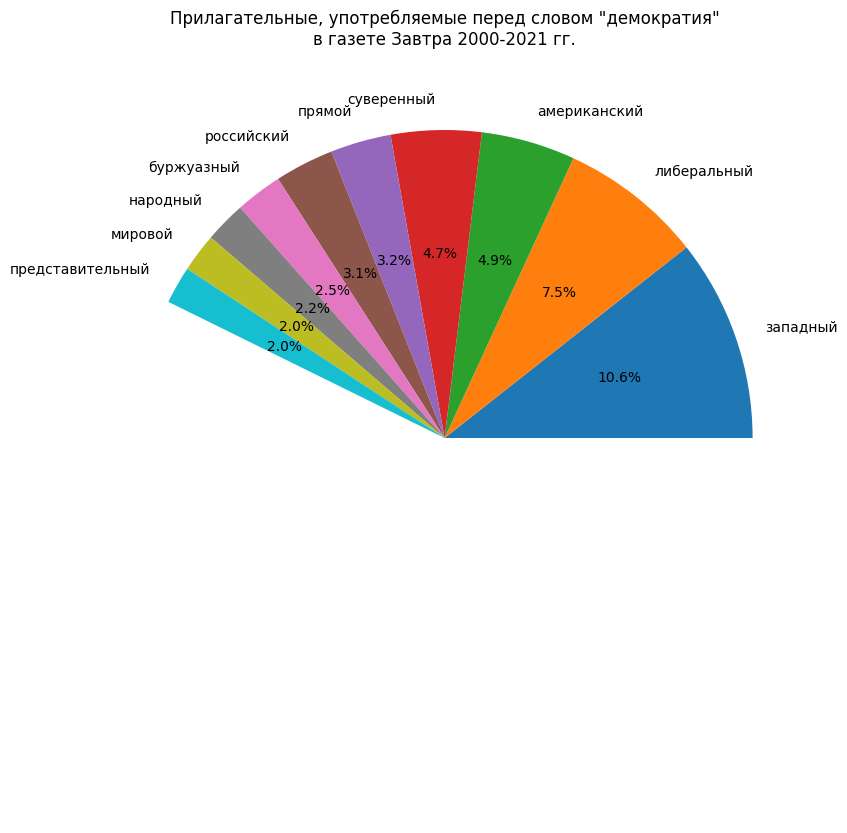

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nв газете Завтра 2000-2021 гг.')
fig.savefig("zavtra_adj_ru.png")

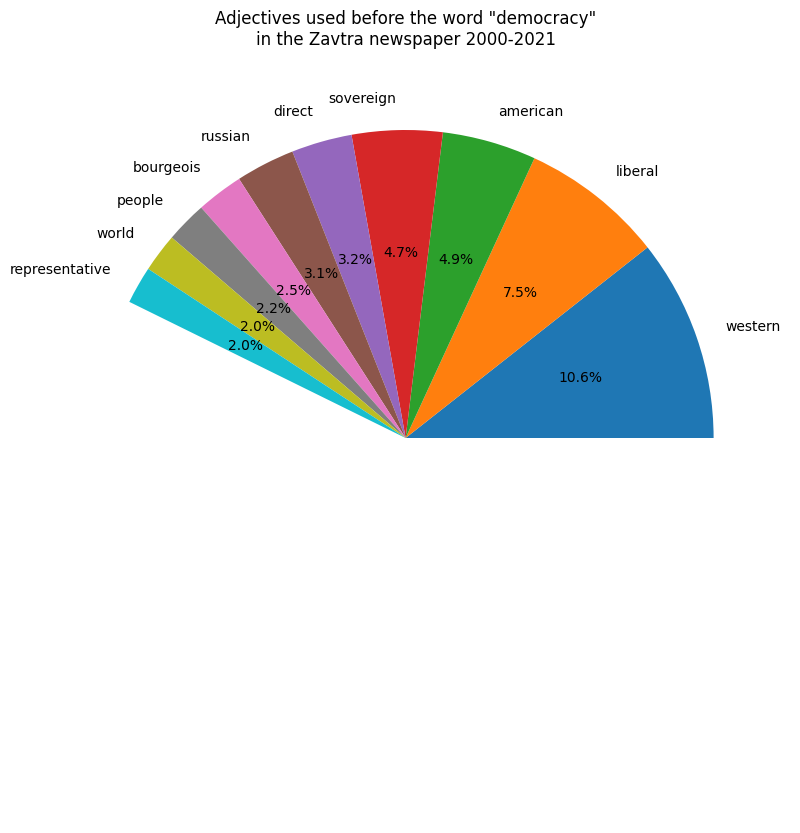

In [4]:
eng = rus.copy()
eng['Word'] = ['western', 'liberal', 'american', 'sovereign', 'direct', 'russian', 'bourgeois', 'people', 'world', 'representative', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\nin the Zavtra newspaper 2000-2021')
fig.savefig("zavtra_adj_en.png")

In [9]:
%%time
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from ZAVTRA""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5)
model.save("zavtra.model")
model.wv.save("zavtra.wordvectors")
model.wv.most_similar('демократия')

CPU times: total: 1h 56min 14s
Wall time: 56min 49s


[('демократический', 0.5446717143058777),
 ('парламентаризм', 0.5352784395217896),
 ('народовластие', 0.52460116147995),
 ('авторитаризм', 0.5060085654258728),
 ('тирания', 0.49900853633880615),
 ('либерализм', 0.4936319589614868),
 ('диктатура', 0.48254847526550293),
 ('автократия', 0.4676496386528015),
 ('плюрализм', 0.46167173981666565),
 ('демос', 0.43891650438308716)]

In [5]:
cur.close()
conn.close()